In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as st
from scipy.signal import argrelextrema
from scipy.stats.mstats import kendalltau
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import os
import random
import seaborn as sns

params = {"xtick.direction": "in", "ytick.direction": "in"}
plt.rcParams.update(params)

In [2]:
# Opening bleaching reports table and filtering no bleaching occurrences
bleaching_table = pd.read_csv('bleaching-reports-table.csv')
bleaching_table = bleaching_table[bleaching_table['Severity_Code'] != 0]
bleaching_table = bleaching_table.reset_index()
del bleaching_table['index']
bleaching_table

,Site_ID,Sample_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Realm_Name,Country_Name,Ecoregion,Site_Name,...,Date_Month,Date_Year,Depth_max_m,Bleaching_Level,S1,S2,S3,S4,S_rounded_mean,Severity_Code
0,1652,10317590,Reef_Check,-17.997111,-38.671306,Atlantic,Tropical Atlantic,Brazil,EST,NaN,...,3,2002,7.5,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1653,10317557,Reef_Check,-17.970278,-38.671806,Atlantic,Tropical Atlantic,Brazil,EST,NaN,...,4,2005,7.0,1.0,2.0,2.0,2.0,2.0,2.0,1
2,1653,10317560,Reef_Check,-17.970278,-38.671806,Atlantic,Tropical Atlantic,Brazil,EST,NaN,...,3,2002,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1654,10317592,Reef_Check,-17.968306,-38.713306,Atlantic,Tropical Atlantic,Brazil,EST,NaN,...,3,2002,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1654,10317593,Reef_Check,-17.968306,-38.713306,Atlantic,Tropical Atlantic,Brazil,EST,NaN,...,3,2002,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,47,53,Morais and Santos (2022),-7.036980,-34.588020,Atlantic,Tropical Atlantic,Brazil,NST,Paraiba Eastern Coast reefs,...,2,2017,61.0,NaN,NaN,NaN,NaN,NaN,NaN,3
169,48,54,Costa (2022),-4.924722,-37.110000,Atlantic,Tropical Atlantic,Brazil,NST,Upanema beach,...,12,2017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2
170,49,55,Mariano (2022),-23.545281,-45.030363,Atlantic,Tropical Atlantic,Brazil,SEST,Ubatuba,...,2,2021,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3
171,50,56,Castro et al. (1999),-17.983300,-39.250000,Atlantic,Tropical Atlantic,Brazil,EST,Abrolhos Viçosa reef,...,9,1992,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
# Filtering table to select only one representative sample from each site (i.e. excluding duplicate locations)
unique_site_ids_table = bleaching_table.drop_duplicates(subset=['Site_ID'], keep='first')
unique_site_ids_table = unique_site_ids_table.reset_index()
unique_site_ids_table

,index,Site_ID,Sample_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Realm_Name,Country_Name,Ecoregion,...,Date_Month,Date_Year,Depth_max_m,Bleaching_Level,S1,S2,S3,S4,S_rounded_mean,Severity_Code
0,0,1652,10317590,Reef_Check,-17.997111,-38.671306,Atlantic,Tropical Atlantic,Brazil,EST,...,3,2002,7.5,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1,1653,10317557,Reef_Check,-17.970278,-38.671806,Atlantic,Tropical Atlantic,Brazil,EST,...,4,2005,7.0,1.0,2.0,2.0,2.0,2.0,2.0,1
2,3,1654,10317592,Reef_Check,-17.968306,-38.713306,Atlantic,Tropical Atlantic,Brazil,EST,...,3,2002,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1
3,5,1655,10317591,Reef_Check,-17.963194,-38.700306,Atlantic,Tropical Atlantic,Brazil,EST,...,3,2002,2.5,NaN,NaN,NaN,NaN,NaN,NaN,1
4,6,1656,10317586,Reef_Check,-17.962694,-38.670194,Atlantic,Tropical Atlantic,Brazil,EST,...,4,2005,8.0,1.0,2.0,2.0,2.0,2.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,167,46,52,Braz et al. (2022),-16.403530,-38.980978,Atlantic,Tropical Atlantic,Brazil,EST,...,6,2019,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3
130,168,47,53,Morais and Santos (2022),-7.036980,-34.588020,Atlantic,Tropical Atlantic,Brazil,NST,...,2,2017,61.0,NaN,NaN,NaN,NaN,NaN,NaN,3
131,169,48,54,Costa (2022),-4.924722,-37.110000,Atlantic,Tropical Atlantic,Brazil,NST,...,12,2017,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2
132,170,49,55,Mariano (2022),-23.545281,-45.030363,Atlantic,Tropical Atlantic,Brazil,SEST,...,2,2021,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3


In [4]:
# Opening SST data over each bleaching sample location

# Daily SST
crw_sst = xr.open_dataset('CRW_SST_SampleIDs.nc')
crw_sst = crw_sst.load()

# Maximum Monthly Mean
crw_climatology = xr.open_mfdataset('CRW_MMM_SampleIDs.nc')
crw_climatology = crw_climatology.load()

# SST standard deviation
crw_sst_std = xr.open_dataset('CRW_sigma_SampleIDs.nc')
crw_sst_std = crw_sst_std.load()

In [5]:
crw_sst_std

<xarray.Dataset>
Dimensions:    (Sample_ID: 258)
Coordinates:
    latitude   (Sample_ID) float32 -23.83 -23.52 -5.375 ... -13.68 -12.82 -13.18
    longitude  (Sample_ID) float32 -45.42 -45.03 -35.28 ... -38.92 -38.22 -38.72
  * Sample_ID  (Sample_ID) int64 1 2 3 4 ... 10323852 10323853 10323854 10323855
Data variables:
    CRW_SST    (Sample_ID) float32 2.36 2.239 0.9534 1.07 ... 1.164 1.125 1.161

In [6]:
# Degree Heating Week (DHW) function (Skirving et al. 2020)
# For the DHWsigma2, the SST variability is included as hotspot threshold
def dhw(id):
    sst_id = crw_sst.sel(Sample_ID=id)
    sst_id = sst_id.to_dataframe()
    sst_id = sst_id['CRW_SST']
    sst_id_mmm = crw_climatology.sst_clim_mmm.sel(Sample_ID=id)
    sigma_id = crw_sst_std['CRW_SST'].sel(Sample_ID=id).data


    hotspot = sst_id - sst_id_mmm.data
    hotspot[hotspot < sigma_id] = 0 # 1 = Bleaching Threshold (MMM + 1ºC)
    hotspot = hotspot/7
    
    DHW = hotspot.rolling(84, min_periods=1).sum()
    #DHW = pd.DataFrame(DHW)
    #DHW = DHW.clip(upper=20)

    return DHW

# Function for finding DHW Peaks in a moving window = 84 days
def bleaching_peaks(df):
    n = 84
    df = pd.DataFrame(df)
    df = df.replace(0, np.nan)
    df = df.dropna(how='all', axis=0)
    df = df.replace(np.nan, 0)
    df['max'] = df.iloc[argrelextrema(df.CRW_SST.values, np.greater_equal,
                                      order=n)[0]]['CRW_SST']

    dhw_peaks = df['max'].drop_duplicates()
    dhw_peaks = dhw_peaks.dropna(how='all', axis=0)
    dhw_peaks = dhw_peaks[dhw_peaks > 0] 
    return dhw_peaks

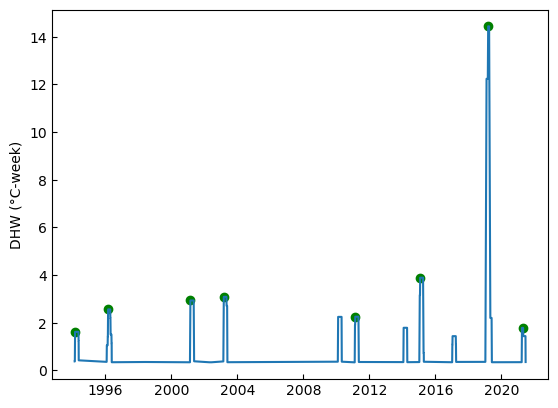

In [7]:
# Checking DHW Peaks function output for a dummy sample_id
id_dummy = 1
df = dhw(id_dummy)
df = pd.DataFrame(df)
df = df.replace(0, np.nan)
df = df.dropna(how='all', axis=0)
df = df.replace(np.nan, 0)

n = 84  # 84 days moving window. Note that reducing this value more DHW peaks will be identified.

# Find local peaks
df['max'] = df.iloc[argrelextrema(df.CRW_SST.values, np.greater_equal,
                    order=n)[0]]['CRW_SST']

dhw_peaks = df['max'].drop_duplicates()
dhw_peaks = dhw_peaks.dropna(how='all', axis=0)
dhw_peaks = dhw_peaks[dhw_peaks > 0]  


# Plot results
plt.scatter(dhw_peaks.index, dhw_peaks, c='g')
plt.plot(df.index, df['CRW_SST'])
plt.ylabel('DHW (°C-week)')
plt.show()

In [8]:
bleaching_record_0 = [] # No bleaching
bleaching_record_1 = [] # Mild bleaching
bleaching_record_2 = [] # Moderate bleaching
bleaching_record_3 = [] # Severe bleaching

# Criando listas para armazenar o datetime de cada pico de DHW
bleaching_record_0_index = []
bleaching_record_1_index = []
bleaching_record_2_index = []
bleaching_record_3_index = []

id_reference_0 = [] # Criando listas para armazenar o PatchId de cada pico de DHW
id_reference_1 = []
id_reference_2 = []
id_reference_3 = []

for i in unique_site_ids_table['Sample_ID']:
    dhw_peaks = bleaching_peaks(dhw(i))
    for j in range(len(dhw_peaks)):
            if dhw_peaks[j] < 4.0:
                bleaching_record_0.append(dhw_peaks[j])
                bleaching_record_0_index.append(dhw_peaks[j:j+1].index)
                id_reference_0.append(i)
                
            if 4.0 <= dhw_peaks[j] < 8.0:
                bleaching_record_1.append(dhw_peaks[j])
                bleaching_record_1_index.append(dhw_peaks[j:j+1].index)
                id_reference_1.append(i)
                
            elif 8.0 <= dhw_peaks[j] < 12.0:
                bleaching_record_2.append(dhw_peaks[j])
                bleaching_record_2_index.append(dhw_peaks[j:j+1].index)
                id_reference_2.append(i)

            elif 12.0 <= dhw_peaks[j]:
                bleaching_record_3.append(dhw_peaks[j])
                bleaching_record_3_index.append(dhw_peaks[j:j+1].index)
                id_reference_3.append(i)

In [9]:
# Organizing the information for stacking the data
df_0 = pd.DataFrame(bleaching_record_0, columns=['DHW'])
df_0_id = pd.DataFrame(id_reference_0, columns=['Sample_ID'])
df_0['Sample_ID'] = df_0_id['Sample_ID']
index = np.array(bleaching_record_0_index)
index = index.flatten()
no_bleaching = df_0.set_index(keys=index)
no_bleaching_con = no_bleaching.sort_index()
for i in range(len(no_bleaching_con)):
    no_bleaching_con['Sample_ID'][i] = no_bleaching_con['Sample_ID'][i]

df_1 = pd.DataFrame(bleaching_record_1, columns=['DHW'])
df_1_id = pd.DataFrame(id_reference_1, columns=['Sample_ID'])
df_1['Sample_ID'] = df_1_id['Sample_ID']
index = np.array(bleaching_record_1_index)
index = index.flatten()
mild_bleaching = df_1.set_index(keys=index)
mild_bleaching_con = mild_bleaching.sort_index()
for i in range(len(mild_bleaching_con)):
    mild_bleaching_con['Sample_ID'][i] = mild_bleaching_con['Sample_ID'][i]

df_2 = pd.DataFrame(bleaching_record_2, columns=['DHW'])
df_2_id = pd.DataFrame(id_reference_2, columns=['Sample_ID'])
df_2['Sample_ID'] = df_2_id['Sample_ID']
index = np.array(bleaching_record_2_index)
index = index.flatten()
moderate_bleaching = df_2.set_index(keys=index)
moderate_bleaching_con = moderate_bleaching.sort_index()
for i in range(len(moderate_bleaching_con)):
    moderate_bleaching_con['Sample_ID'][i] = moderate_bleaching_con['Sample_ID'][i]

df_3 = pd.DataFrame(bleaching_record_3, columns=['DHW'])
df_3_id = pd.DataFrame(id_reference_3, columns=['Sample_ID'])
df_3['Sample_ID'] = df_3_id['Sample_ID']
index = np.array(bleaching_record_3_index)
index = index.flatten()
severe_bleaching = df_3.set_index(keys=index)
severe_bleaching_con = severe_bleaching.sort_index()
for i in range(len(severe_bleaching_con)):
    severe_bleaching_con['Sample_ID'][i] = severe_bleaching_con['Sample_ID'][i]

C:\Users\xavie\AppData\Local\Temp\ipykernel_9796\1402104238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_bleaching_con['Sample_ID'][i] = no_bleaching_con['Sample_ID'][i]
C:\Users\xavie\AppData\Local\Temp\ipykernel_9796\1402104238.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mild_bleaching_con['Sample_ID'][i] = mild_bleaching_con['Sample_ID'][i]
C:\Users\xavie\AppData\Local\Temp\ipykernel_9796\1402104238.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [10]:
# Adding severity codes for each bleaching severity
no_bleaching_con['Estimated_Severity_Code'] = 0.0
mild_bleaching_con['Estimated_Severity_Code'] = 1.0
moderate_bleaching_con['Estimated_Severity_Code'] = 2.0
severe_bleaching_con['Estimated_Severity_Code'] = 3.0

In [11]:
# Stacking DHW peaks
stack = pd.concat([mild_bleaching_con,moderate_bleaching_con],ignore_index=True)
stack = pd.concat([stack,severe_bleaching_con],ignore_index=True)
stack['Sample_ID'] = stack['Sample_ID'].astype(np.int64)

# Merging the stacked dataset to our original bleaching table
# Essentialy, this table represents each bleaching event that was predicted by the DHWsigma1 method
# Its length corresponds to the total number of predicted events
# The predicted severity can be seen in 'Estimated_Severity_Code' column
new_stack = stack.merge(bleaching_table.drop_duplicates(subset=['Sample_ID']), how='inner')
new_stack.to_csv('stack/predicted-bleaching-events-dhwsigma2.csv',index=False) # You can save this table
new_stack

,DHW,Sample_ID,Estimated_Severity_Code,Site_ID,Data_Source,Latitude_Degrees,Longitude_Degrees,Ocean_Name,Realm_Name,Country_Name,...,Date_Month,Date_Year,Depth_max_m,Bleaching_Level,S1,S2,S3,S4,S_rounded_mean,Severity_Code
0,4.964288,55,1.0,49,Mariano (2022),-23.545281,-45.030363,Atlantic,Tropical Atlantic,Brazil,...,2,2021,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3
1,6.625717,55,1.0,49,Mariano (2022),-23.545281,-45.030363,Atlantic,Tropical Atlantic,Brazil,...,2,2021,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2,6.617146,55,1.0,49,Mariano (2022),-23.545281,-45.030363,Atlantic,Tropical Atlantic,Brazil,...,2,2021,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3
3,7.874289,55,1.0,49,Mariano (2022),-23.545281,-45.030363,Atlantic,Tropical Atlantic,Brazil,...,2,2021,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3
4,5.382860,55,1.0,49,Mariano (2022),-23.545281,-45.030363,Atlantic,Tropical Atlantic,Brazil,...,2,2021,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,14.531436,10317592,3.0,1654,Reef_Check,-17.968306,-38.713306,Atlantic,Tropical Atlantic,Brazil,...,3,2002,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1
489,14.411418,10317561,3.0,1695,Reef_Check,-17.962500,-38.695556,Atlantic,Tropical Atlantic,Brazil,...,6,2009,3.0,1.0,2.0,1.0,0.0,0.0,1.0,1
490,14.411418,10317557,3.0,1653,Reef_Check,-17.970278,-38.671806,Atlantic,Tropical Atlantic,Brazil,...,4,2005,7.0,1.0,2.0,2.0,2.0,2.0,2.0,1
491,14.531436,10317566,3.0,1692,Reef_Check,-17.964333,-38.700667,Atlantic,Tropical Atlantic,Brazil,...,4,2005,5.5,1.0,2.0,2.0,2.0,2.0,2.0,1


C:\Users\xavie\AppData\Local\Temp\ipykernel_9796\2052723726.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys_r', 5)


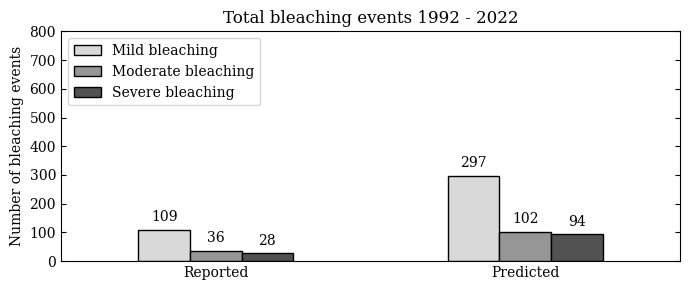

In [12]:
# Let's plot our first figure regarding the total number of bleaching events reported vs. predicted

from pylab import *

cmap = cm.get_cmap('Greys_r', 5)
cmap = cmap.reversed()
colors_cmap = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    colors_cmap.append(rgba)
colors_cmap = colors_cmap[1:4]
colors_cmap

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
mild_reported = bleaching_table[bleaching_table['Severity_Code'] == 1]
mild_reported = mild_reported[(mild_reported['Date_Year'] >= 1992)]
moderate_reported = bleaching_table[bleaching_table['Severity_Code'] == 2]
moderate_reported = moderate_reported[(moderate_reported['Date_Year'] >= 1992)]
severe_reported = bleaching_table[bleaching_table['Severity_Code'] == 3]
severe_reported = severe_reported[(severe_reported['Date_Year'] >= 1992)]

mild = [len(mild_reported), len(mild_bleaching_con)]
moderate = [len(moderate_reported), len(moderate_bleaching_con)]
severe = [len(severe_reported), len(severe_bleaching_con)]

colors = colors_cmap

indices = ['Reported', 'Predicted']

df = pd.DataFrame(np.c_[mild,moderate,severe], index=indices)
ax = df.plot.bar(figsize=(7,3), rot=0, color = colors, edgecolor = 'black',zorder=2)
plt.ylim(top=800)
plt.tick_params(direction="in")
#plt.grid(color='lightgray', linestyle='dashed',zorder=1)
ax.yaxis.set_ticks_position('both')
#ax.xaxis.set_ticks_position('both')
plt.title('Total bleaching events 1992 - 2022')
plt.ylabel('Number of bleaching events')
plt.legend(["Mild bleaching", "Moderate bleaching", 'Severe bleaching'], loc='upper left')
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, size=10, zorder=3,padding=4)
plt.tight_layout()
#plt.savefig('final_figures/total-bleaching-comparison-dhwsigma2.png', dpi=300)

In [13]:
# Spliting the dates of bleaching peaks for easy manipulation
series_reported_bleaching = pd.DataFrame({'year': bleaching_table['Date_Year'],
                   'month': bleaching_table['Date_Month'],
                   'day': bleaching_table['Date_Day'],
                   'Sample_ID': bleaching_table['Sample_ID']})
df2 = pd.DataFrame({'year': bleaching_table['Date_Year'],
                   'month': bleaching_table['Date_Month'],
                   'day': bleaching_table['Date_Day']})
df2 = pd.to_datetime(df2)
series_reported_bleaching['time'] = df2
series_reported_bleaching = series_reported_bleaching.sort_values(by='Sample_ID')
series_reported_bleaching = series_reported_bleaching.reset_index()

# Stacking the splitted dates
no_bleaching_con['time'] = no_bleaching_con.index
mild_bleaching_con['time'] = mild_bleaching_con.index
moderate_bleaching_con['time'] = moderate_bleaching_con.index
severe_bleaching_con['time'] = severe_bleaching_con.index
stack = pd.concat([mild_bleaching_con,moderate_bleaching_con],ignore_index=True)
stack = pd.concat([stack,severe_bleaching_con],ignore_index=True)
#stack = pd.concat([stack,no_bleaching_con],ignore_index=True) As explained in the manuscript, no bleaching data was disregarded. Uncomment for stacking it together.
stack['Sample_ID'] = stack['Sample_ID'].astype(np.int64)
stack = stack.sort_values(by='Sample_ID')
stack = stack.reset_index()
stack

,index,DHW,Sample_ID,Estimated_Severity_Code,time
0,424,14.435711,1,3.0,2019-03-15 12:00:00
1,422,16.895719,2,3.0,2019-03-13 12:00:00
2,170,4.932858,2,1.0,2015-02-14 12:00:00
3,56,5.411431,2,1.0,2001-02-26 12:00:00
4,119,5.301430,2,1.0,2010-02-17 12:00:00
...,...,...,...,...,...
488,274,4.981431,10323853,1.0,2022-04-16 12:00:00
489,173,6.040004,10323853,1.0,2016-04-15 12:00:00
490,346,8.311434,10323855,2.0,2019-05-09 12:00:00
491,174,4.692860,10323855,1.0,2016-04-15 12:00:00


In [14]:
# Here we start our matchup analysis, the idea is to find the closest DHW peaks to each bleaching report
closest_bleaching_peaks = pd.DataFrame(columns=['DHW','Sample_ID','Estimated_Severity_Code','time'])
lDHW = []
lSample_ID = []
lEst_Sev_Code = []
lTime = []
error_list = []

for i in range(len(series_reported_bleaching['Sample_ID'])):
    
    dummy_series = series_reported_bleaching['Sample_ID'][i]
               
    dummy_stack = stack[stack['Sample_ID']==dummy_series]
    dummy_stack = dummy_stack.set_index('time')
    dummy_stack = dummy_stack.sort_index()
    
    if i == 0:
        try:
            closest_before = dummy_stack.truncate(after=series_reported_bleaching['time'][i])
            closest_before['time'] = closest_before.index
            closest_before['days_diff'] = closest_before['time'] - series_reported_bleaching['time'][i]
            closest_before['days_diff'] = closest_before['days_diff']/np.timedelta64(1, 'D')
            closest_before = closest_before[closest_before['time']==closest_before['time'].max()]
            
            closest_after = dummy_stack.truncate(before=series_reported_bleaching['time'][i])
            closest_after['time'] = closest_after.index
            closest_after['days_diff'] = closest_after['time'] - series_reported_bleaching['time'][i]
            closest_after['days_diff'] = closest_after['days_diff']/np.timedelta64(1, 'D')
            closest_after = closest_after[closest_after['time']==closest_after['time'].max()]
        except:
            error_list.append(series_reported_bleaching['time'][i])
            pass
    else:
        dummy_closest_before = dummy_stack.truncate(after=series_reported_bleaching['time'][i])
        dummy_closest_before['time'] = dummy_closest_before.index
        dummy_closest_before['days_diff'] = dummy_closest_before['time'] - series_reported_bleaching['time'][i]
        dummy_closest_before['days_diff'] = dummy_closest_before['days_diff']/np.timedelta64(1, 'D')
        dummy_closest_before = dummy_closest_before[dummy_closest_before['time']==dummy_closest_before['time'].max()]

        dummy_closest_after = dummy_stack.truncate(before=series_reported_bleaching['time'][i])
        dummy_closest_after['time'] = dummy_closest_after.index
        dummy_closest_after['days_diff'] = dummy_closest_after['time'] - series_reported_bleaching['time'][i]
        dummy_closest_after['days_diff'] = dummy_closest_after['days_diff']/np.timedelta64(1, 'D')
        dummy_closest_after = dummy_closest_after[dummy_closest_after['time']==dummy_closest_after['time'].min()]            

        closest_before = pd.concat([closest_before,dummy_closest_before])
        closest_after = pd.concat([closest_after,dummy_closest_after])

In [15]:
# Finding the closest DHW peak within an 3-month interval
final_closest_before = closest_before[closest_before['days_diff'] >= -84]
final_closest_after = closest_after[closest_after['days_diff'] <= 84]
closest_peaks = pd.concat([final_closest_before,final_closest_after])

In [16]:
# Merging it with our original bleaching table
bleaching_peak_to_report = closest_peaks.merge(bleaching_table.drop_duplicates(subset=['Sample_ID']), how='left')
bleaching_peak_to_report.to_csv('stack/matched-bleaching-events-dhwsigma2.csv',index=False)

In [17]:
# Not pretty at all, but just calculating the false/true negatives/positives for our DHW matched predictions
true_positives_mild = bleaching_peak_to_report[bleaching_peak_to_report['Estimated_Severity_Code']==1]
true_positives_mild = len(true_positives_mild[true_positives_mild['Severity_Code']==1])
false_positives_mild = bleaching_peak_to_report[bleaching_peak_to_report['Estimated_Severity_Code']==1]
false_positives_mild = len(false_positives_mild[false_positives_mild['Severity_Code']!=1])
false_negatives_mild = bleaching_peak_to_report[bleaching_peak_to_report['Severity_Code']==1]
false_negatives_mild = len(false_negatives_mild[false_negatives_mild['Estimated_Severity_Code']!=1])

true_positives_moderate = bleaching_peak_to_report[bleaching_peak_to_report['Estimated_Severity_Code']==2]
true_positives_moderate = len(true_positives_moderate[true_positives_moderate['Severity_Code']==2])
false_positives_moderate = bleaching_peak_to_report[bleaching_peak_to_report['Estimated_Severity_Code']==2]
false_positives_moderate = len(false_positives_moderate[false_positives_moderate['Severity_Code']!=2])
false_negatives_moderate = bleaching_peak_to_report[bleaching_peak_to_report['Severity_Code']==2]
false_negatives_moderate = len(false_negatives_moderate[false_negatives_moderate['Estimated_Severity_Code']!=2])

true_positives_severe = bleaching_peak_to_report[bleaching_peak_to_report['Estimated_Severity_Code']==3]
true_positives_severe = len(true_positives_severe[true_positives_severe['Severity_Code']==3])
false_positives_severe = bleaching_peak_to_report[bleaching_peak_to_report['Estimated_Severity_Code']==3]
false_positives_severe = len(false_positives_severe[false_positives_severe['Severity_Code']!=3])
false_negatives_severe = bleaching_peak_to_report[bleaching_peak_to_report['Severity_Code']==3]
false_negatives_severe = len(false_negatives_severe[false_negatives_severe['Estimated_Severity_Code']!=3])

Mild_sensitivity = true_positives_mild/(false_negatives_mild+true_positives_mild)
Moderate_sensitivity = true_positives_moderate/(false_negatives_moderate+true_positives_moderate)
Severe_sensitivity = true_positives_severe/(false_negatives_severe+true_positives_severe)

Mild_precision = true_positives_mild/(true_positives_mild+false_positives_mild)
Moderate_precision = true_positives_moderate/(true_positives_moderate+false_positives_moderate)
Severe_precision = true_positives_severe/(true_positives_severe+false_positives_severe)

print('Mild_sensitivity: ', Mild_sensitivity)
print('Moderate_sensitivity: ', Moderate_sensitivity)
print('Severe_sensitivity: ', Severe_sensitivity)
print('')
print('Mild_precision: ', Mild_precision)
print('Moderate_precision: ', Moderate_precision)
print('Severe_precision: ', Severe_precision)

Mild_sensitivity:  0.3333333333333333
Moderate_sensitivity:  0.0
Severe_sensitivity:  0.4444444444444444

Mild_precision:  0.25
Moderate_precision:  0.0
Severe_precision:  0.4


C:\Users\xavie\AppData\Local\Temp\ipykernel_9796\2816724094.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys_r', 5)


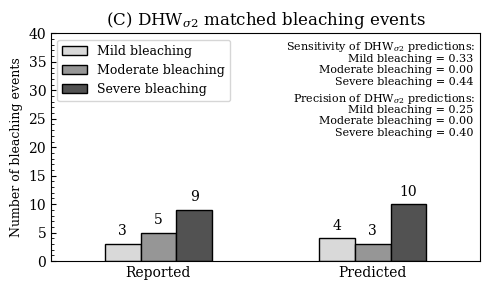

In [18]:
# Let's plot our second figure regarding the matched number of bleaching events reported vs. predicted

from pylab import *

cmap = cm.get_cmap('Greys_r', 5)
cmap = cmap.reversed()
colors_cmap = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    colors_cmap.append(rgba)
colors_cmap = colors_cmap[1:4]
colors_cmap

mild = [len(np.where(bleaching_peak_to_report['Severity_Code']==1)[0]), 
        len(np.where(bleaching_peak_to_report['Estimated_Severity_Code']==1)[0])]
moderate = [len(np.where(bleaching_peak_to_report['Severity_Code']==2)[0]),
            len(np.where(bleaching_peak_to_report['Estimated_Severity_Code']==2)[0])]
severe = [len(np.where(bleaching_peak_to_report['Severity_Code']==3)[0]), 
          len(np.where(bleaching_peak_to_report['Estimated_Severity_Code']==3)[0])]

colors = colors_cmap

indices = ['Reported', 'Predicted']

df = pd.DataFrame(np.c_[mild,moderate,severe], index=indices)
ax = df.plot.bar(figsize=(5,3), rot=0, color = colors, edgecolor = 'black',zorder=2)
plt.ylim(top=40)
plt.tick_params(direction="in")
#plt.grid(color='lightgray', linestyle='dashed',zorder=1)
ax.yaxis.set_ticks_position('left')
#ax.xaxis.set_ticks_position('both')
plt.title('(C) DHW$_{\sigma 2}$ matched bleaching events')
plt.ylabel('Number of bleaching events',fontsize=9)
plt.legend(["Mild bleaching", "Moderate bleaching", 'Severe bleaching'], loc='upper left',fontsize=9)
ax.text(s='Sensitivity of DHW$_{\sigma 2}$ predictions:',y=37,x=1.480,size=8, ha="right")
ax.text(s='Mild bleaching = {:.2f}'.format(Mild_sensitivity), y=35,x=1.47,size=8, ha="right")
ax.text(s='Moderate bleaching = {:.2f}'.format(Moderate_sensitivity), y=33,x=1.47,size=8, ha="right")
ax.text(s='Severe bleaching = {:.2f}'.format(Severe_sensitivity), y=31,x=1.47,size=8, ha="right")
ax.text(s='Precision of DHW$_{\sigma 2}$ predictions:',y=28,x=1.480,size=8, ha="right")
ax.text(s='Mild bleaching = {:.2f}'.format(Mild_precision), y=26,x=1.47,size=8, ha="right")
ax.text(s='Moderate bleaching = {:.2f}'.format(Moderate_precision), y=24,x=1.47,size=8, ha="right")
ax.text(s='Severe bleaching = {:.2f}'.format(Severe_precision), y=22,x=1.47,size=8, ha="right")
ax.yaxis.set_minor_locator(MultipleLocator(1))
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, size=10, zorder=3,padding=4)
plt.tight_layout()
plt.savefig('final_figures/matched/dhw_sigma2.png', dpi=300)

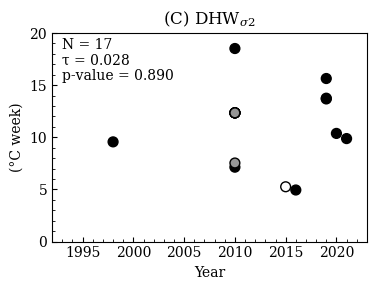

In [19]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
plt.ylim(top=40)
plt.xlim(1992,2023)
plt.scatter(bleaching_peak_to_report['Date_Year'],bleaching_peak_to_report['DHW'],c=bleaching_peak_to_report['Severity_Code'],
            marker='o',edgecolor='black',cmap='Greys',s=50,zorder=2)
plt.xlabel('Year')
plt.ylabel('(°C week)')
#ident = [0, 2000]
#plt.plot([1993,2022],[1,19],zorder=1,linewidth=0.25,ls='--',color='red')
plt.ylim(0,20)
ax.text(s='N = {}'.format(len(bleaching_peak_to_report)),x=1993,y=18.5,size=10)
ax.text(s='τ = {:.3f}'.format(kendalltau(bleaching_peak_to_report['DHW'],bleaching_peak_to_report['Date_Year'])[0]),x=1993,y=17.0,size=10)
ax.text(s='p-value = {:.3f}'.format(kendalltau(bleaching_peak_to_report['DHW'],bleaching_peak_to_report['Date_Year'])[1]),x=1993,y=15.5,size=10)
plt.tick_params(direction="in")
ax.yaxis.set_ticks_position('left')
label=['Severe bleaching']
#plt.legend()

ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.title('(C) DHW$_{\sigma 2}$')

#plt.plot(2027, 13.0, 'ro', color='white', markeredgecolor='black')
#plt.text(2026.75, 12.5, 'Mild bleaching', size=9)

#plt.plot(2027, 11.5, 'ro', color='lightgray', markeredgecolor='black')
#plt.text(2026.75, 11.0, 'Moderate bleaching', size=9)

#plt.plot(2027, 10.0, 'ro', color='black', markeredgecolor='black')
#plt.text(202.75, 9.5, 'Severe bleaching', size=9)

plt.tight_layout()
plt.savefig('final_figures/kendall/dhw_sigma2.png', dpi=300)